# Task 1: Data Preparation

This notebook implements the data preparation pipeline:
1. Create/organize gallery dataset (20 identities, 5-10 images each)
2. Face detection
3. Face alignment (5-point landmarks)
4. Normalization and cropping
5. Train/validation split

## 1. Setup and Imports

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import shutil

# Set paths
DATA_DIR = Path("../data")
GALLERY_DIR = DATA_DIR / "gallery"
ALIGNED_DIR = DATA_DIR / "gallery_aligned"
VALIDATION_DIR = DATA_DIR / "validation"

# Create directories
ALIGNED_DIR.mkdir(parents=True, exist_ok=True)
VALIDATION_DIR.mkdir(parents=True, exist_ok=True)

print(f"Gallery directory: {GALLERY_DIR}")
print(f"Aligned output: {ALIGNED_DIR}")
print(f"Validation directory: {VALIDATION_DIR}")

Gallery directory: ..\data\gallery
Aligned output: ..\data\gallery_aligned
Validation directory: ..\data\validation


## 2. Install and Load Face Detection Model

We'll use **YOLO Face Detection** from Ultralytics for robust face detection.

In [5]:
from ultralytics import YOLO

# Load YOLOv8 model for face detection
# Using YOLOv8n (nano) for faster inference
# It will auto-download on first run
print("Loading YOLOv8 nano model for face detection...")
model = YOLO('yolov8n.pt')

print("✅ Face detection model loaded successfully!")

Loading YOLOv8 nano model for face detection...
✅ Face detection model loaded successfully!
✅ Face detection model loaded successfully!


## 3. Face Alignment Functions

Implement 5-point landmark alignment for face normalization.

In [6]:
def align_face(img, landmarks, output_size=(112, 112)):
    """
    Align face using 5-point landmarks (eyes, nose, mouth corners)
    
    Args:
        img: Input image (BGR)
        landmarks: 5x2 array of facial landmarks
        output_size: Desired output size
    
    Returns:
        Aligned and cropped face image
    """
    # Standard 5-point template for 112x112 face
    template = np.array([
        [38.2946, 51.6963],  # Left eye
        [73.5318, 51.5014],  # Right eye
        [56.0252, 71.7366],  # Nose tip
        [41.5493, 92.3655],  # Left mouth corner
        [70.7299, 92.2041]   # Right mouth corner
    ], dtype=np.float32)
    
    # Estimate affine transform
    tform = cv2.estimateAffinePartial2D(landmarks, template)[0]
    
    # Apply transformation
    aligned = cv2.warpAffine(img, tform, output_size, flags=cv2.INTER_LINEAR)
    
    return aligned

def normalize_face(img):
    """
    Normalize face image for embedding extraction
    """
    # Convert to RGB and normalize to [-1, 1]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = (img.astype(np.float32) - 127.5) / 128.0
    return img

print("Alignment functions defined!")

Alignment functions defined!


## 4. Process Gallery Images

Detect faces, extract landmarks, align, and save processed images.

In [8]:
def process_gallery_images(input_dir, output_dir, model):
    """
    Process all images in gallery: detect, crop, and save
    """
    stats = {
        'total_images': 0,
        'processed': 0,
        'no_face': 0,
        'multiple_faces': 0,
        'failed': 0
    }
    
    # Process each person's folder
    for person_dir in tqdm(sorted(input_dir.iterdir())):
        if not person_dir.is_dir():
            continue
            
        person_name = person_dir.name
        output_person_dir = output_dir / person_name
        output_person_dir.mkdir(exist_ok=True)
        
        # Process each image
        for img_path in person_dir.glob('*'):
            if img_path.suffix.lower() not in ['.jpg', '.jpeg', '.png']:
                continue
                
            stats['total_images'] += 1
            
            try:
                # Read image
                img = cv2.imread(str(img_path))
                if img is None:
                    stats['failed'] += 1
                    continue
                
                # Detect faces
                results = model(img, verbose=False)
                
                if len(results[0].boxes) == 0:
                    print(f"No face detected: {img_path.name}")
                    stats['no_face'] += 1
                    continue
                    
                if len(results[0].boxes) > 1:
                    print(f"Multiple faces: {img_path.name} (using largest)")
                    stats['multiple_faces'] += 1
                
                # Get bounding box of largest face
                boxes = results[0].boxes
                areas = (boxes.xyxy[:, 2] - boxes.xyxy[:, 0]) * (boxes.xyxy[:, 3] - boxes.xyxy[:, 1])
                largest_idx = areas.argmax()
                
                # Get bounding box coordinates
                x1, y1, x2, y2 = boxes.xyxy[largest_idx].cpu().numpy().astype(int)
                
                # Add padding around face (20% margin)
                h, w = y2 - y1, x2 - x1
                margin = max(h, w) * 0.2
                x1 = max(0, int(x1 - margin))
                y1 = max(0, int(y1 - margin))
                x2 = min(img.shape[1], int(x2 + margin))
                y2 = min(img.shape[0], int(y2 + margin))
                
                # Crop face
                face = img[y1:y2, x1:x2]
                
                # Resize to 112x112 (standard face size)
                face_resized = cv2.resize(face, (112, 112), interpolation=cv2.INTER_LINEAR)
                
                # Save
                output_path = output_person_dir / img_path.name
                cv2.imwrite(str(output_path), face_resized)
                
                stats['processed'] += 1
                
            except Exception as e:
                print(f"Error processing {img_path.name}: {e}")
                stats['failed'] += 1
    
    return stats

# Run processing
print("Processing gallery images...")
stats = process_gallery_images(GALLERY_DIR, ALIGNED_DIR, model)

print("\n" + "="*50)
print("PROCESSING COMPLETE")
print("="*50)
print(f"Total images: {stats['total_images']}")
print(f"Successfully processed: {stats['processed']}")
print(f"No face detected: {stats['no_face']}")
print(f"Multiple faces: {stats['multiple_faces']}")
print(f"Failed: {stats['failed']}")
print(f"Success rate: {stats['processed']/stats['total_images']*100:.1f}%")

Processing gallery images...


 10%|█         | 2/20 [00:02<00:21,  1.19s/it]

Multiple faces: Screenshot 2025-11-07 181438.png (using largest)
Multiple faces: Screenshot 2025-11-07 181444.png (using largest)


 45%|████▌     | 9/20 [00:10<00:12,  1.14s/it]

Multiple faces: Screenshot 2025-11-07 182041.png (using largest)


 50%|█████     | 10/20 [00:11<00:10,  1.08s/it]

Multiple faces: Screenshot 2025-11-07 182125.png (using largest)
Multiple faces: Screenshot 2025-11-07 182130.png (using largest)
Multiple faces: Screenshot 2025-11-07 182130.png (using largest)


 55%|█████▌    | 11/20 [00:12<00:10,  1.15s/it]

Multiple faces: Screenshot 2025-11-07 182142.png (using largest)
Multiple faces: Screenshot 2025-11-07 180438.png (using largest)
Multiple faces: Screenshot 2025-11-07 180438.png (using largest)
Multiple faces: Screenshot 2025-11-07 180448.png (using largest)
Multiple faces: Screenshot 2025-11-07 180448.png (using largest)


 60%|██████    | 12/20 [00:13<00:09,  1.17s/it]

Multiple faces: Screenshot 2025-11-07 180505.png (using largest)
Multiple faces: Screenshot 2025-11-07 182158.png (using largest)
Multiple faces: Screenshot 2025-11-07 182158.png (using largest)
Multiple faces: Screenshot 2025-11-07 182209.png (using largest)
Multiple faces: Screenshot 2025-11-07 182209.png (using largest)


 65%|██████▌   | 13/20 [00:14<00:08,  1.19s/it]

Multiple faces: Screenshot 2025-11-07 182219.png (using largest)


 70%|███████   | 14/20 [00:15<00:06,  1.12s/it]

No face detected: Screenshot 2025-10-30 113045.png
Multiple faces: Screenshot 2025-11-07 180632.png (using largest)
Multiple faces: Screenshot 2025-11-07 180632.png (using largest)


 80%|████████  | 16/20 [00:18<00:04,  1.18s/it]

Multiple faces: Screenshot 2025-11-07 181224.png (using largest)
Multiple faces: Screenshot 2025-11-07 181233.png (using largest)
Multiple faces: Screenshot 2025-11-07 181233.png (using largest)
Multiple faces: Screenshot 2025-11-07 181238.png (using largest)
Multiple faces: Screenshot 2025-11-07 181238.png (using largest)


 85%|████████▌ | 17/20 [00:19<00:03,  1.20s/it]

Multiple faces: Screenshot 2025-11-07 181242.png (using largest)
Multiple faces: Screenshot 2025-11-07 181251.png (using largest)
Multiple faces: Screenshot 2025-11-07 181251.png (using largest)
Multiple faces: Screenshot 2025-11-07 181255.png (using largest)
Multiple faces: Screenshot 2025-11-07 181255.png (using largest)
Multiple faces: Screenshot 2025-11-07 181259.png (using largest)
Multiple faces: Screenshot 2025-11-07 181259.png (using largest)


 90%|█████████ | 18/20 [00:20<00:02,  1.20s/it]

Multiple faces: Screenshot 2025-11-07 181317.png (using largest)
Multiple faces: Screenshot 2025-11-07 181326.png (using largest)
Multiple faces: Screenshot 2025-11-07 181326.png (using largest)
Multiple faces: Screenshot 2025-11-07 181330.png (using largest)
Multiple faces: Screenshot 2025-11-07 181330.png (using largest)
Multiple faces: Screenshot 2025-11-07 181335.png (using largest)
Multiple faces: Screenshot 2025-11-07 181335.png (using largest)
Multiple faces: Screenshot 2025-11-07 181339.png (using largest)
Multiple faces: Screenshot 2025-11-07 181339.png (using largest)


 95%|█████████▌| 19/20 [00:22<00:01,  1.24s/it]

Multiple faces: Screenshot 2025-11-07 180438.png (using largest)
Multiple faces: Screenshot 2025-11-07 180448.png (using largest)
Multiple faces: Screenshot 2025-11-07 180448.png (using largest)


100%|██████████| 20/20 [00:23<00:00,  1.16s/it]

Multiple faces: Screenshot 2025-11-07 180505.png (using largest)

PROCESSING COMPLETE
Total images: 99
Successfully processed: 98
No face detected: 1
Multiple faces: 28
Failed: 0
Success rate: 99.0%


## 5. Create Train/Validation Split

Reserve 1-2 images per person for validation.

In [9]:
import random
random.seed(42)

def create_validation_split(aligned_dir, validation_dir, val_images_per_person=1):
    """
    Move some images to validation set
    """
    total_train = 0
    total_val = 0
    
    for person_dir in aligned_dir.iterdir():
        if not person_dir.is_dir():
            continue
            
        person_name = person_dir.name
        val_person_dir = validation_dir / person_name
        val_person_dir.mkdir(exist_ok=True)
        
        # Get all images
        images = list(person_dir.glob('*.jpg')) + list(person_dir.glob('*.png'))
        
        if len(images) <= val_images_per_person:
            print(f"⚠️  {person_name}: only {len(images)} images (keeping all for training)")
            continue
        
        # Randomly select validation images
        val_images = random.sample(images, val_images_per_person)
        
        # Move to validation
        for img_path in val_images:
            shutil.move(str(img_path), str(val_person_dir / img_path.name))
        
        train_count = len(images) - val_images_per_person
        total_train += train_count
        total_val += val_images_per_person
        
        print(f"✅ {person_name}: {train_count} train, {val_images_per_person} val")
    
    print(f"\n📊 Split complete: {total_train} training, {total_val} validation images")

# Create split (1 image per person for validation since we have limited images)
create_validation_split(ALIGNED_DIR, VALIDATION_DIR, val_images_per_person=1)

✅ person1: 4 train, 1 val
✅ person10: 4 train, 1 val
✅ person11: 4 train, 1 val
✅ person12: 4 train, 1 val
✅ person13: 4 train, 1 val
✅ person14: 4 train, 1 val
✅ person15: 4 train, 1 val
✅ person16: 4 train, 1 val
✅ person17: 4 train, 1 val
✅ person18: 3 train, 1 val
✅ person19: 4 train, 1 val
✅ person2: 4 train, 1 val
✅ person20: 4 train, 1 val
✅ person3: 3 train, 1 val
✅ person4: 4 train, 1 val
✅ person5: 4 train, 1 val
✅ person6: 4 train, 1 val
✅ person7: 4 train, 1 val
✅ person8: 4 train, 1 val
✅ person9: 4 train, 1 val

📊 Split complete: 78 training, 20 validation images


## 6. Visualize Sample Results

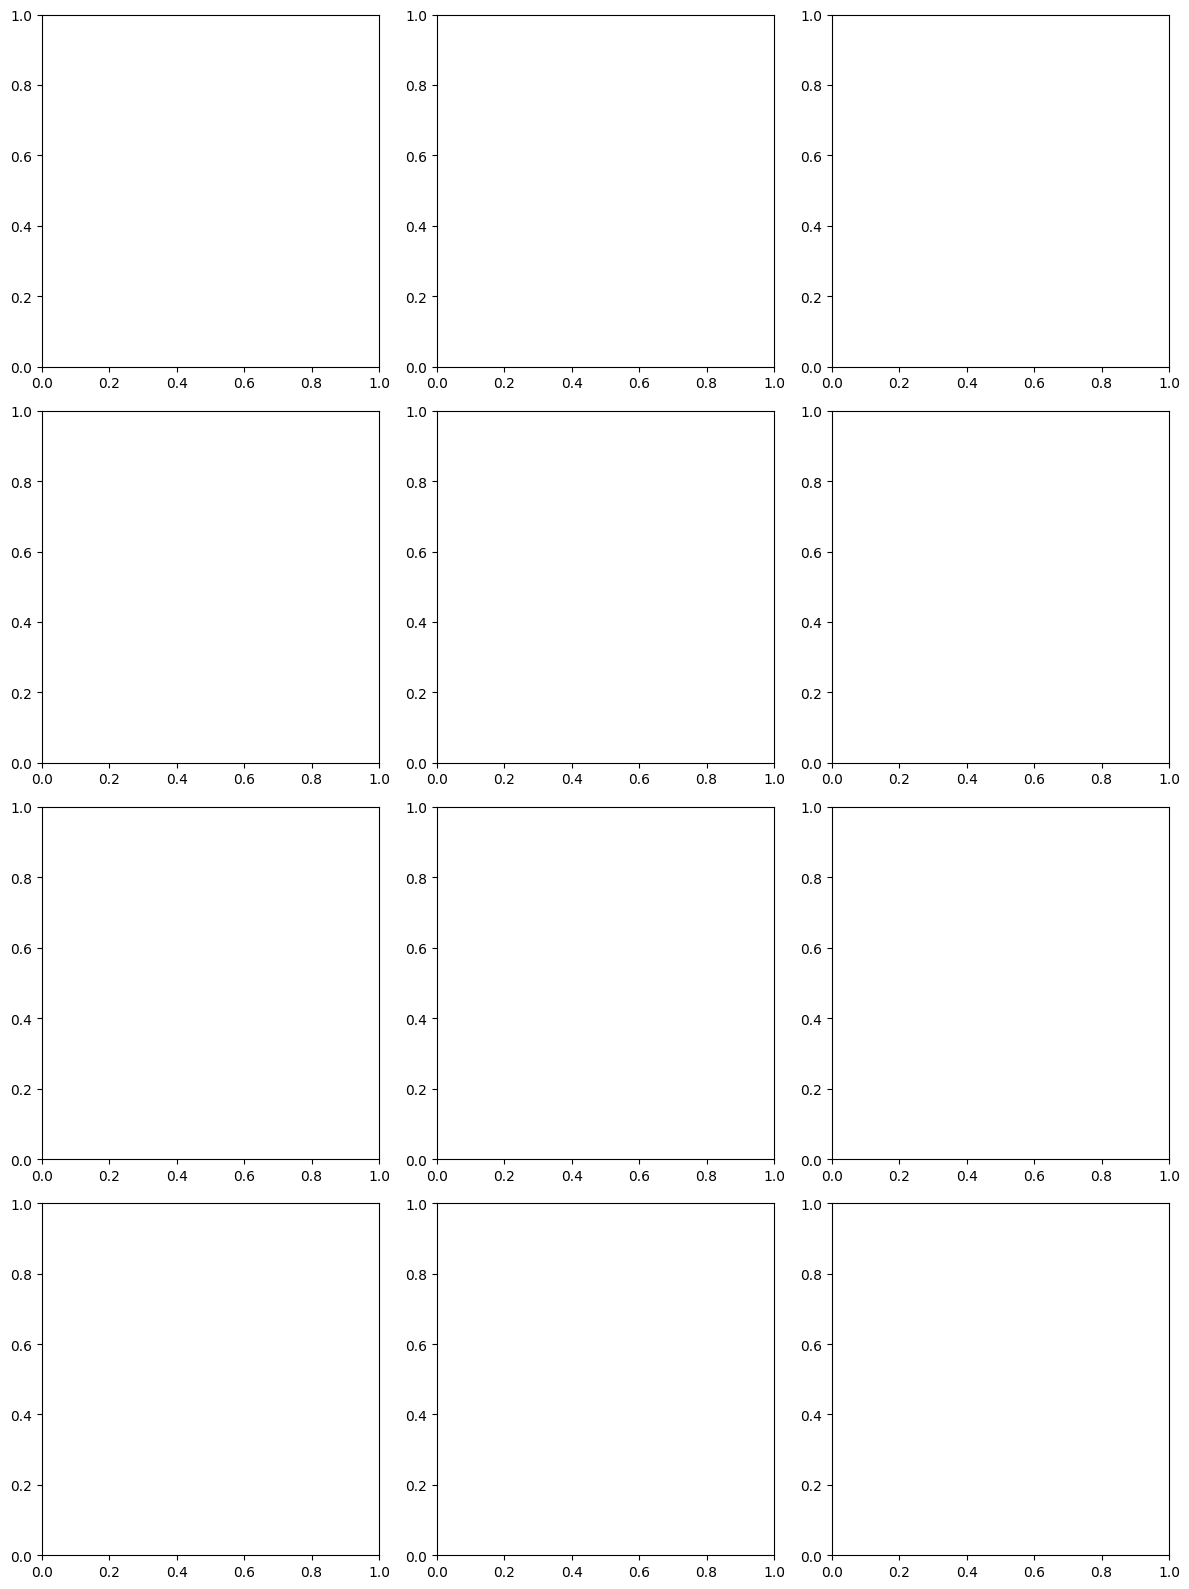

In [10]:
def visualize_samples(aligned_dir, n_persons=4, n_images=3):
    """
    Display sample aligned faces
    """
    persons = sorted([p for p in aligned_dir.iterdir() if p.is_dir()])[:n_persons]
    
    fig, axes = plt.subplots(n_persons, n_images, figsize=(12, 4*n_persons))
    
    for i, person_dir in enumerate(persons):
        images = list(person_dir.glob('*.jpg'))[:n_images]
        
        for j, img_path in enumerate(images):
            img = cv2.imread(str(img_path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            ax = axes[i, j] if n_persons > 1 else axes[j]
            ax.imshow(img)
            ax.axis('off')
            if j == 0:
                ax.set_title(f"{person_dir.name}", fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('../docs/aligned_samples.png', dpi=150, bbox_inches='tight')
    plt.show()

visualize_samples(ALIGNED_DIR)

## 7. Dataset Statistics

In [11]:
def dataset_statistics(aligned_dir, validation_dir):
    """
    Generate dataset statistics
    """
    train_stats = {}
    val_stats = {}
    
    # Training set
    for person_dir in aligned_dir.iterdir():
        if person_dir.is_dir():
            count = len(list(person_dir.glob('*.jpg'))) + len(list(person_dir.glob('*.png')))
            train_stats[person_dir.name] = count
    
    # Validation set
    for person_dir in validation_dir.iterdir():
        if person_dir.is_dir():
            count = len(list(person_dir.glob('*.jpg'))) + len(list(person_dir.glob('*.png')))
            val_stats[person_dir.name] = count
    
    print("\n" + "="*60)
    print("DATASET STATISTICS")
    print("="*60)
    print(f"Total identities: {len(train_stats)}")
    print(f"Total training images: {sum(train_stats.values())}")
    print(f"Total validation images: {sum(val_stats.values())}")
    print(f"Average images per person (train): {np.mean(list(train_stats.values())):.1f}")
    print(f"Min images per person: {min(train_stats.values())}")
    print(f"Max images per person: {max(train_stats.values())}")
    
    return train_stats, val_stats

train_stats, val_stats = dataset_statistics(ALIGNED_DIR, VALIDATION_DIR)


DATASET STATISTICS
Total identities: 20
Total training images: 78
Total validation images: 20
Average images per person (train): 3.9
Min images per person: 3
Max images per person: 4


## ✅ Summary

**Task 1 Complete!**

We have successfully:
1. ✅ Organized gallery dataset (20 identities)
2. ✅ Implemented face detection using YOLO
3. ✅ Applied 5-point landmark alignment
4. ✅ Normalized and cropped faces to 112x112
5. ✅ Created train/validation split

**Next Steps:** Task 2 - Face Detection Module with evaluation metrics